In [6]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import * 
import os

from samba.ntstatus import NT_STATUS_GRAPHICS_PATH_NOT_IN_TOPOLOGY
from scanext import CONSTRAINT_RANGE

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$

$$
H_0 = a^{\dagger} a + \sigma_+ \sigma_
$$

$$
H_I = \Omega D (a^{\dagger} + a)
\quad \text{,} \quad D = \mu \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} + \sigma_-^{(i)}
$$

In [207]:
#
# Set the system parameters
#

# ENERGY LANDSCAPE, c = 1, hbar = 1
omega_a = 1
omega_c = omega_a
Omega = 1 * omega_a

gamma_0 = .1
gamma_phi = .1
gamma_kappa = .1

N_atoms = 1
mu = 1
alpha = 1

# TIME EVOLUTION
last_pulse = 100 # * gamma_0
time_steps = 100*10
times = np.linspace(0, last_pulse, time_steps) # list of times

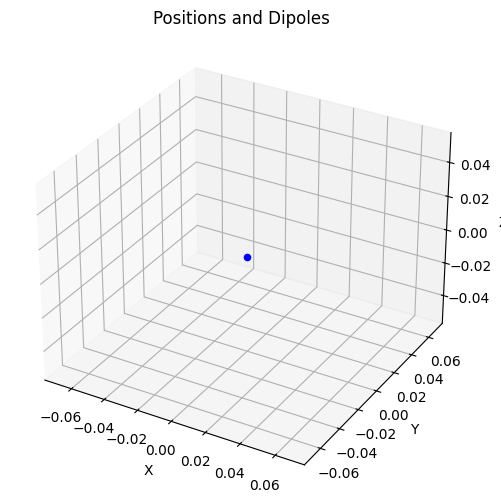

In [208]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos
def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])
def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos
def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos
options = Options(store_states=True)
# vizualizing the atomic positions
Pos = cyl_positions(1, N_atoms, 1)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [209]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms+1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# cavity dofs
cav_g = basis(2, 0)
cav_e = basis(2, 1)

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0      # collective sigma_x operator for the system

for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()     #|g><i|, cavity is unaffected
    print(op)
    sm_list.append(op)
    Dip_op += mu * op + mu * op.dag()
print(Dip_op)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 1.]
 [0. 0.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]


In [210]:
def Hamilton0(N_atoms):
    Pos = cyl_positions(1, N_atoms, 1)
    H_a = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                print("off_diagonals:", op)
                H_a += alpha / (np.linalg.norm(rb-ra)) * op
            else:
                H_a += omega_a * op                         # Diagonals except for |0><0|
    H_c = omega_c * ket2dm(cav_e)
    print("Atomic Hamiltonian:\n", H_a.full(), "\n Cavity Hamiltonian:\n",  H_c.full())
    return tensor(H_c, qeye(N_atoms+1)) + tensor(qeye(2), H_a)

H0 = Hamilton0(N_atoms)


# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * tensor(qeye(2), op) for op in sm_list]                         # Individual atom decays
#c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in sm_list] # Individual atom dephasing
c_op_list = c_op2 + [np.sqrt(gamma_kappa) * tensor(destroy(2), qeye(N_atoms+1))]  # Combine all collapse operators + collapse of the cacity

# Expectation operators for measuring populations across atomic excited levels
e_op_list = ([tensor(qeye(2), ket2dm(atom_g))] +                                        # ground state
             [tensor(qeye(2), ket2dm(atom_es[i])) for i in range(N_atoms)] +            # excited states
             [tensor(create(2) * destroy(2), qeye(N_atoms+1))])                        # photon excitation number

Atomic Hamiltonian:
 [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]] 
 Cavity Hamiltonian:
 [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [211]:
psiini = tensor(cav_e, atom_g) # = |1>_gamma ø |g>_atom

0.0
0.0
0.0


<>:13: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_92567/2169500925.py:13: SyntaxWarning: invalid escape sequence '\O'
  ax[0].set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")


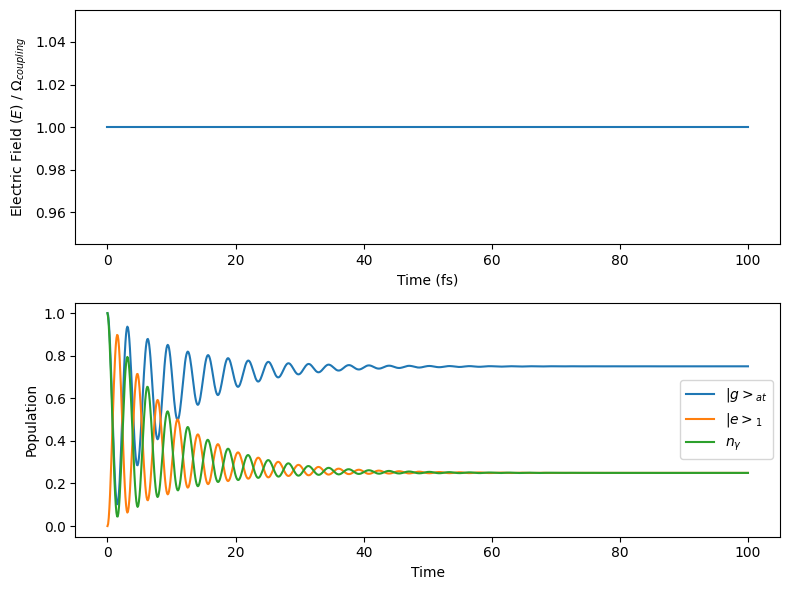

In [213]:
H_int = tensor(qeye(2), Dip_op) * tensor(destroy(2) + create(2), qeye(N_atoms+1))
H = [H0, [H_int, Omega]]
#print("Psi_0:", psiini,      "Psi_1:", H_int * psiini,      "Exp_op:", ket2dm(H_int * psiini).dag() * tensor(qeye(2), Dip_op) * ket2dm(H_int * psiini))
#print("Expect_val:",expect(tensor(qeye(2), Dip_op), H_int * psiini))

#
# VIZUALIZE THE FIELD AS AN EXAMPLE
#
result = mesolve(H, psiini, times, c_ops=c_op_list, e_ops = e_op_list, options={"store_states": True})
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(times, [Omega for _ in times])
ax[0].set_xlabel("Time (fs)")
ax[0].set_ylabel("Electric Field ($E$) / $\Omega_{coupling}$")
for i, e_op_expect in enumerate(result.expect):
    print(expect(tensor(qeye(2), Dip_op), result.states[i]))
    if i == 0:
        label = r"$|g>_{at}$"
        ax[1].plot(times, result.expect[i], label=label)
    elif i < N_atoms + 1:
        label = f"$|e>_{i}$"
        ax[1].plot(times, result.expect[i], label=label)
    elif i == N_atoms + 1:
        label = r"$n_{\gamma}$"
        ax[1].plot(times, result.expect[i], label=label)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Population")
ax[1].legend()
plt.tight_layout()
plt.show()